# Analysis of historical crytocurrency data

* Download historical data (from two different sources)
    * One gives is **weekly** data
    * One gives us **daily** data
* Look for strong any patterns between currency pairs/groups

In [396]:
import pandas as pd
import ccxt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import json
import datetime
from time import sleep
import requests

# Getting data using the `ccxt` package [WEEKLY]

Has access to many exchanges, which themselves decide which and how much data you can get.

Finding the best places will require a bit of snooping around online or just trial and error.

#### I went for Bitfinex, as it has the best trade-off between number of possible coins and also liquidity/volume. So prices should be relatively up-to-date.

In [266]:
bitfin = ccxt.bitfinex({'verbose': False})
#bitfin_markets = bitfin.load_markets()

all_markets = bitfin.fetchMarkets()

markets = []
for market in all_markets:
    if market['base'] in targets:
        markets.append(market)

In [296]:
bitfin.describe()

## The most important things:


#  'rateLimit': 1500,
#  'timeframes': {'12h': '12h',
#   '15m': '15m',
#   '1M': '1M',
#   '1d': '1D',
#   '1h': '1h',
#   '1m': '1m',
#   '1w': '7D',
#   '2w': '14D',
#   '30m': '30m',
#   '3h': '3h',
#   '5m': '5m',
#   '6h': '6h'},

{'api': {'private': {'post': ['account_fees',
    'account_infos',
    'balances',
    'basket_manage',
    'credits',
    'deposit/new',
    'funding/close',
    'history',
    'history/movements',
    'key_info',
    'margin_infos',
    'mytrades',
    'mytrades_funding',
    'offer/cancel',
    'offer/new',
    'offer/status',
    'offers',
    'offers/hist',
    'order/cancel',
    'order/cancel/all',
    'order/cancel/multi',
    'order/cancel/replace',
    'order/new',
    'order/new/multi',
    'order/status',
    'orders',
    'orders/hist',
    'position/claim',
    'positions',
    'summary',
    'taken_funds',
    'total_taken_funds',
    'transfer',
    'unused_taken_funds',
    'withdraw']},
  'public': {'get': ['book/{symbol}',
    'lendbook/{currency}',
    'lends/{currency}',
    'pubticker/{symbol}',
    'stats/{symbol}',
    'symbols',
    'symbols_details',
    'tickers',
    'today',
    'trades/{symbol}']},
  'v2': {'get': ['candles/trade:{timeframe}:{symbol}/{sect

In [290]:
# see all the currency pairs we can potentially analyse via Bitfinex
print(bitfin.symbols)

['AID/BTC', 'AID/ETH', 'AID/USD', 'AVT/BTC', 'AVT/ETH', 'AVT/USD', 'BAT/BTC', 'BAT/ETH', 'BAT/USD', 'BCH/BTC', 'BCH/ETH', 'BCH/USD', 'BTC/EUR', 'BTC/USD', 'BTG/BTC', 'BTG/USD', 'DASH/BTC', 'DASH/USD', 'DATA/BTC', 'DATA/ETH', 'DATA/USD', 'EDO/BTC', 'EDO/ETH', 'EDO/USD', 'ELF/BTC', 'ELF/ETH', 'ELF/USD', 'EOS/BTC', 'EOS/ETH', 'EOS/USD', 'ETC/BTC', 'ETC/USD', 'ETH/BTC', 'ETH/USD', 'ETP/BTC', 'ETP/ETH', 'ETP/USD', 'FUN/BTC', 'FUN/ETH', 'FUN/USD', 'GNT/BTC', 'GNT/ETH', 'GNT/USD', 'IOTA/BTC', 'IOTA/ETH', 'IOTA/EUR', 'IOTA/USD', 'LTC/BTC', 'LTC/USD', 'MNA/BTC', 'MNA/ETH', 'MNA/USD', 'NEO/BTC', 'NEO/ETH', 'NEO/USD', 'OMG/BTC', 'OMG/ETH', 'OMG/USD', 'QSH/BTC', 'QSH/ETH', 'QSH/USD', 'QTUM/BTC', 'QTUM/ETH', 'QTUM/USD', 'RCN/BTC', 'RCN/ETH', 'RCN/USD', 'REP/BTC', 'REP/ETH', 'REP/USD', 'RLC/BTC', 'RLC/ETH', 'RLC/USD', 'RRT/BTC', 'RRT/USD', 'SAN/BTC', 'SAN/ETH', 'SAN/USD', 'SNG/BTC', 'SNG/ETH', 'SNG/USD', 'SNT/BTC', 'SNT/ETH', 'SNT/USD', 'SPK/BTC', 'SPK/ETH', 'SPK/USD', 'TNB/BTC', 'TNB/ETH', 'TNB/USD

Create a list of the tickers that we are interested in.

We could add any ones to this list, which are available from one of the exchanges. That is a long list.

In [448]:
# Bitcoin, Ripple, Bitcoin Cash, Etherium, Tron, Lite Coin, Etherium Cash, Dash, Monero
targets = ['BTC', 'XRP', 'BCH', 'ETH', 'TRX', 'LTC', 'ETC', 'DASH', 'XMR']

# Just get the prices all in dollars (might not all be available in pounds or euros)
target_pairs = [target+'/USD' for target in targets]

# have a look
target_pairs

['BTC/USD',
 'XRP/USD',
 'BCH/USD',
 'ETH/USD',
 'TRX/USD',
 'LTC/USD',
 'ETC/USD',
 'DASH/USD',
 'XMR/USD']

### Get data for each target pair

In [356]:
def ohlcv_to_df(response):
    s0 = pd.DataFrame(response, columns=['Date', 'Open', 'High', 'Low', 'Close', 'Volume'])
    s0.Date = s0.Date.apply(lambda x: time.strftime('%d/%m/%Y', time.localtime(x/1000)))
    s0.Date = s0.Date.apply(lambda x: datetime.datetime.strptime(x, "%d/%m/%Y").date())
    s0.set_index('Date', inplace=True)
    return s0

In [403]:
results = {}
for pair in target_pairs:
    pair_data = bitfin.fetch_ohlcv(symbol=pair, timeframe='1w', since=20170101 ,limit=365*2 + 100)
    results[pair] = ohlcv_to_df(pair_data)
#fields: [timestamp (ms since epoch), open, high, low, close, volume]

###  Plot the Prices over the timeline we pulled data for

Can see that onyl Bitcoin has a long history, other coins are young and don't have much historical data!

I go through and trim the dataset down, dropping coins and time-periods where data is too sparse...

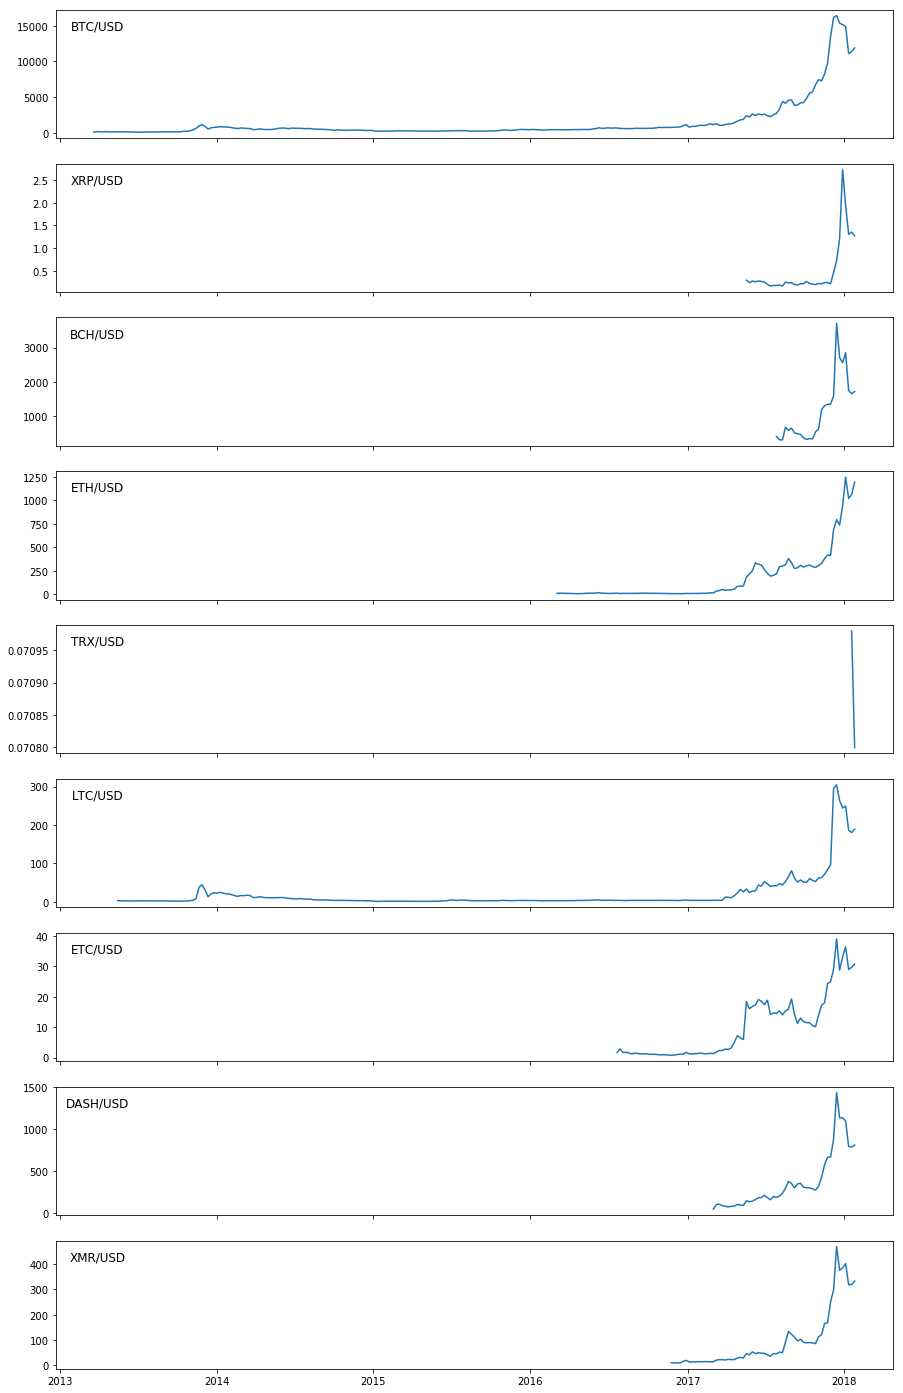

In [404]:
fig, axs = plt.subplots(len(target_pairs), 1, sharex=True)
fig.set_size_inches((15, 25))
for i, (pair, data) in enumerate(results.items()):
    axs[i].plot(data.Close)
    axs[i].set_title(pair, position=(0.05, 0.8))

#results['BTC/USD'].drop('Volume', axis=1).plot(figsize=(15, 10))

### combine the closing prices for all currencies into one table and plot it

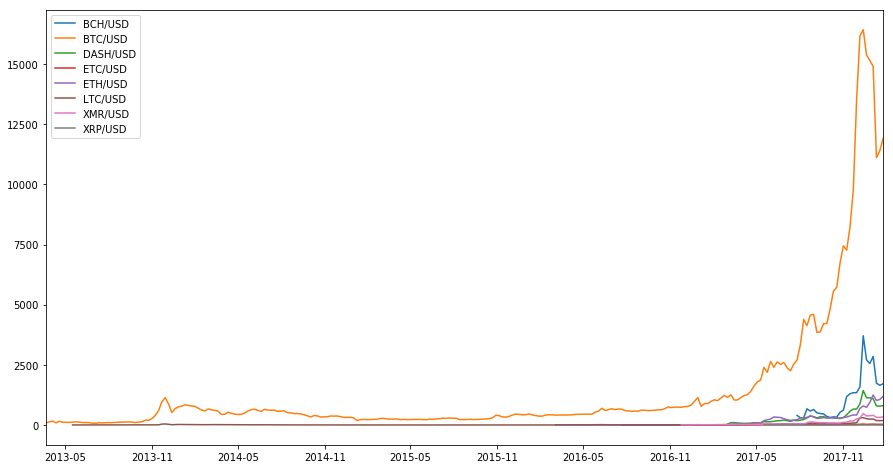

In [405]:
closes = pd.DataFrame(data={pair: data.Close for pair, data in results.items()})
closes.plot(figsize=(15, 8));

#### Most currencies only have data from early 2017, so drop the data before then. Also just drop TRON completely as it only has a week of data!


In [406]:
DF = closes[closes.index > datetime.date(2017, 1, 1)]
closes.drop('TRX/USD', inplace=True, axis=1)    # drop Tron as it only has a few weeks of data

### Do the standard thing with financial data to get all assets on the same scale and more accurately represent observations of returns not being exactly normally distributed:

[Short explanations on Quora](https://www.quora.com/Why-do-people-use-log-returns-of-stock-prices-for-auto-regression?share=1)

In [407]:
# compute the log returns
logdf = np.log(DF).diff()[1:]
logdf.replace(to_replace=[-np.inf, np.inf], value=0.00, inplace=True)

Have a look at the data...

In [409]:
logdf.head()

,BCH/USD,BTC/USD,DASH/USD,ETC/USD,ETH/USD,LTC/USD,XMR/USD,XRP/USD
2017-01-12,NaN,0.129659,NaN,0.017649,0.052416,-0.012603,0.029095,NaN
2017-01-19,NaN,0.006615,NaN,0.059312,0.026261,-0.054042,-0.022443,NaN
2017-01-26,NaN,0.096373,NaN,0.049765,0.016914,0.084735,0.115173,NaN
2017-02-02,NaN,0.064050,NaN,0.062674,0.057086,-0.024065,-0.037828,NaN
2017-02-09,NaN,-0.033842,NaN,-0.124070,0.133974,-0.007039,0.067681,NaN


How many points are missing for each of the currencies?

In [411]:
logdf.isnull().sum()

BCH/USD     29
BTC/USD      0
DASH/USD     8
ETC/USD      0
ETH/USD      0
LTC/USD      0
XMR/USD      0
XRP/USD     19
dtype: int64

#### ... drop BCH and XRP due to lack of data

In [412]:
final = logdf.drop(labels=['BCH/USD', 'XRP/USD'], inplace=False, axis=1)

## Plot the Log returns for each of the remaining currencies

This looks like a mess... like all other stocks if you go through the same processes!

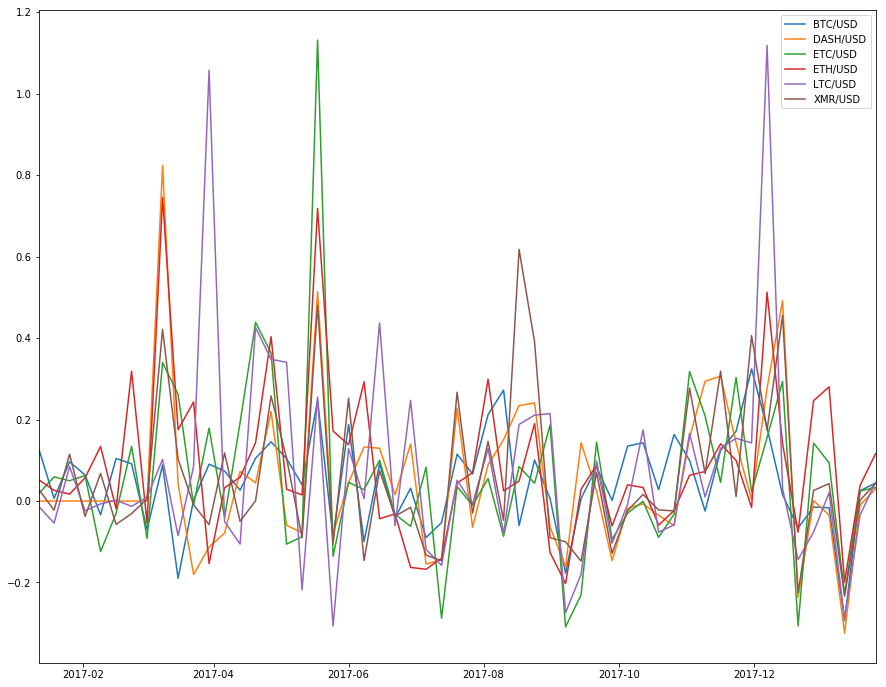

In [418]:
final.plot(figsize=(15, 12))

##  Have a look at the distribution of returns for each of the currency pairs

Here you can see that the regression lines for each of the coins (all based in USD) all go upwards from left to right. This means they are all positively correlated! Some more than others, of course, but basically can say that there isn't really a big amount of diversification that we can 'buy'.

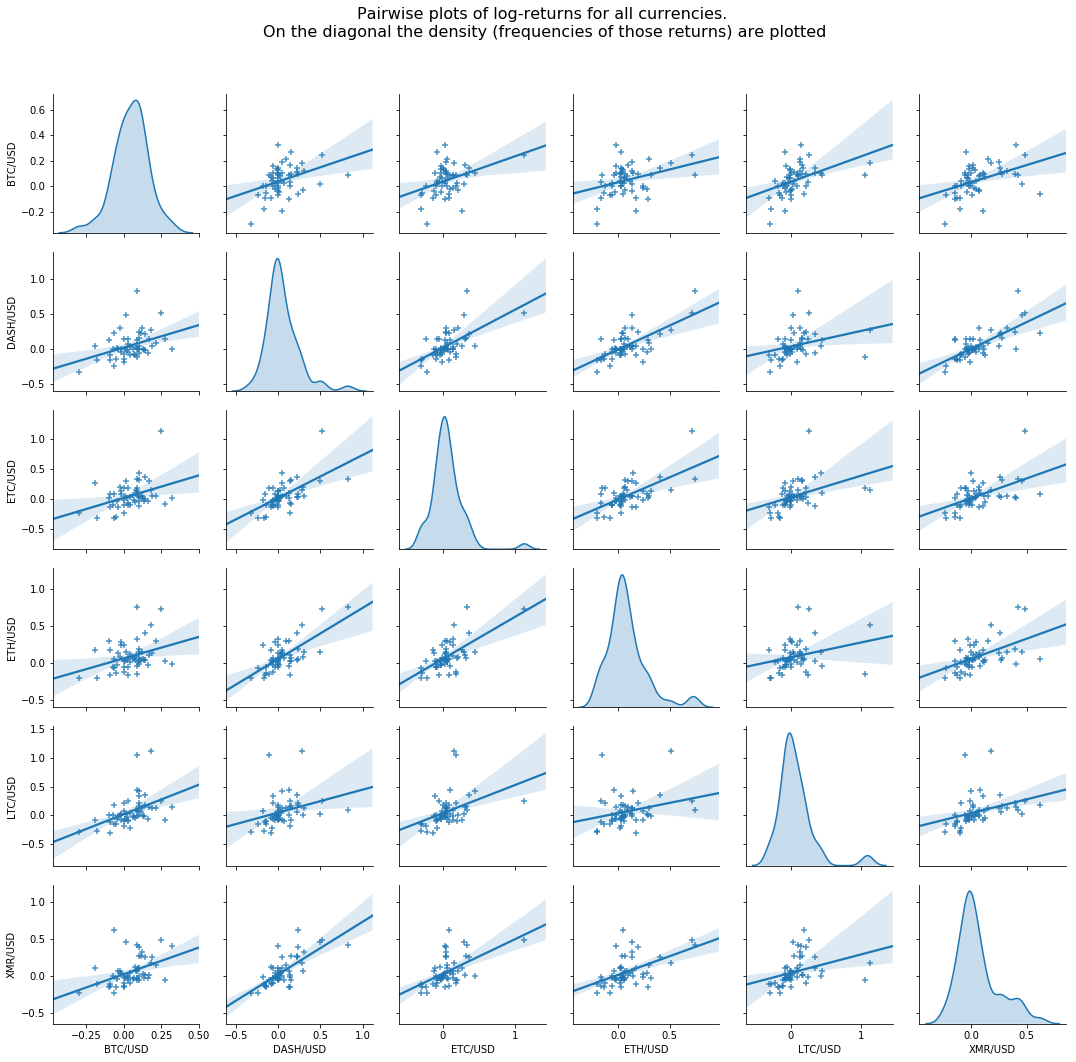

In [460]:
plt.rcParams['figure.figsize'] = (12, 10)
ax = sns.pairplot(final, kind='reg', diag_kind='kde', markers="+",
                  diag_kws={'shade': True})
plt.subplots_adjust(top=0.9)
_ = ax.fig.suptitle('Pairwise plots of log-returns for all currencies. '
                    '\nOn the diagonal the density (frequencies of those returns) are plotted',
                    fontsize=16)

In [417]:
# replace the missing values for DASH with zeros
final.replace(to_replace=np.nan, value=0, inplace=True)

## Have a look at the mean, variance, skew and kurtosis (i.e. the Moments)

Compute and plot each of the moments for each of the coins on a rolling basis. Set a window size of e.g. 8 datapoints = 8 weeks. Shift the window along one week, recompute -> rinse and repeat.

It is another dimension in which we can view the correlation. Also, sometimes the different moments betray bigger trends earlier than simply looking at the messy returns or prices paths plotted at the beginning.

Main takeaways:

* The high correlation is shown by the rolling mean for all currencies being extremely similar
* Bitcoin has a comparatively low variance compared to the other coins -> lower risk!
* Bitcoin, Ehterium and Etherium Cash generally have negative skew, meaning their log-returns are more often positive -> the more stably go up in price.
* There seem to be periods of high kurtosis, which (if memory serves correctly) seem to coincide with the event of a bullish phase.

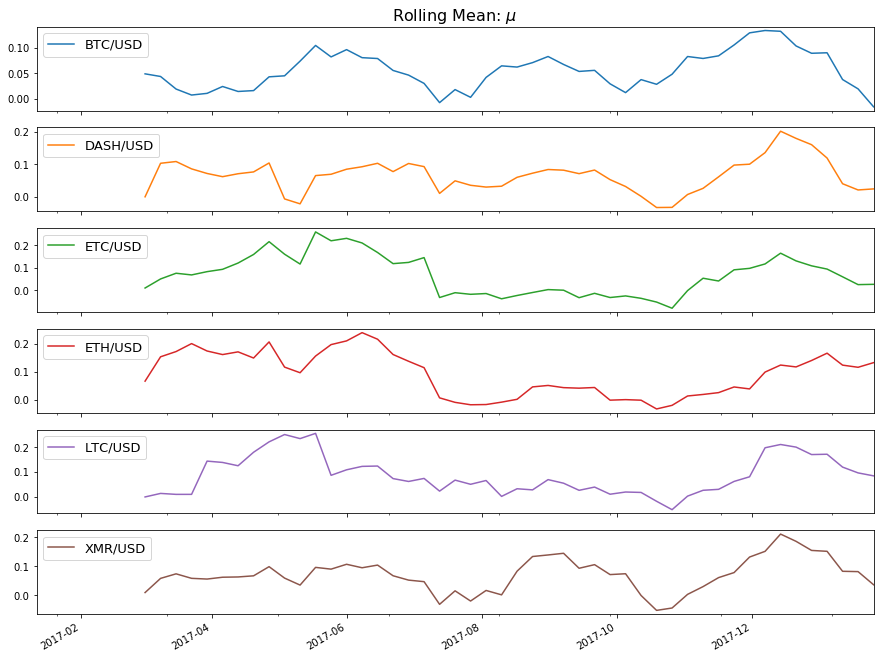

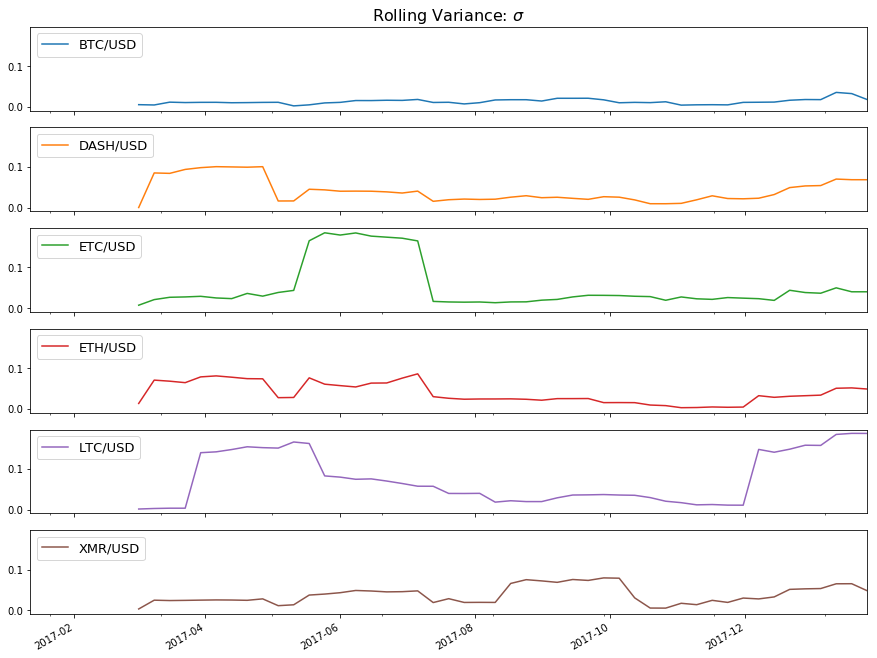

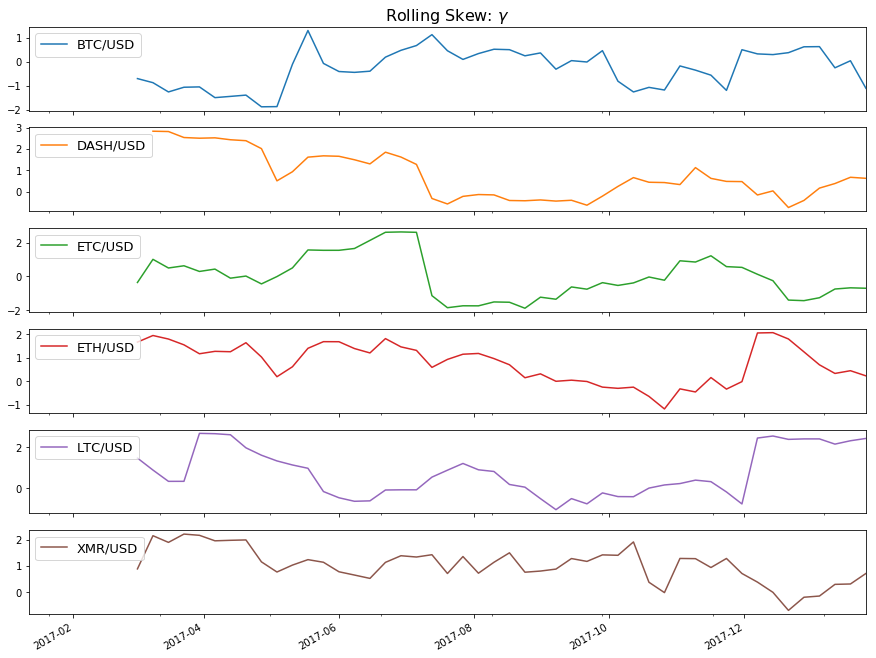

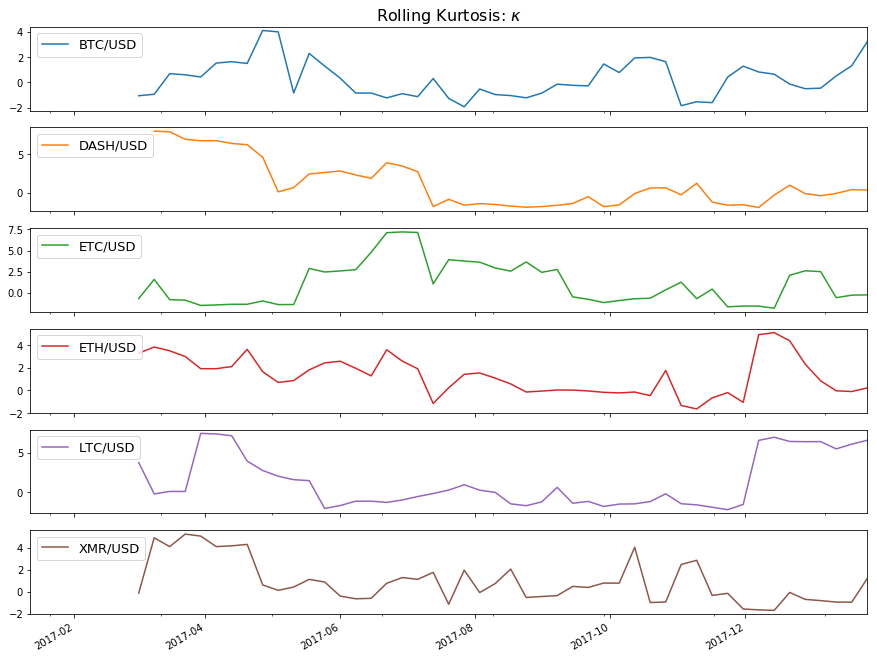

In [491]:
def rolling_moments(df, frame_size=40, legend_loc='center left', fig_size=None,
                    mean=True, variance=True, skew=True, kurtosis=True):
    
    """Plot the moving moments, computed once for each `frame_size` weeks and plotted.
    By default all moments are plotted. Set individual moment _kwargs_ to False in order to not plot them.
    
    data: a Pandas DataFrame (see function DataFrame method `rolling` for more information)
    frame_size: the window size in weeks for which to compute each moment
    legend_loc: passed to the plotting function to specify where the legend should appear
    
    Returns: a tuple of `(fig, axes)` plot objects for each moment specified using the kwargs
    fig: is the figure itself for each moments (controls parameters for the first subplot)
    axes: a list of the `ax` objects for each of the subplots
    
    """

    # create facet plots for each moment, each containing a plot for each variable
    # set the titles accordingly and place the legends all in matching positions
    if mean:
        fig1, *axes1 = df.rolling(window=frame_size).mean().plot(subplots=True, figsize=fig_size)
        fig1.set_title('Rolling Mean: $\mu$', fontsize=16)
        fig1.legend(loc=legend_loc, fontsize=13)
        [ax.legend(loc=legend_loc, fontsize=13) for ax in axes1]
        mean_return = (fig1, axes1)
        
    if variance:
        fig2, *axes2 = df.rolling(window=frame_size).var().plot(subplots=True, figsize=fig_size, sharey=True)
        fig2.set_title('Rolling Variance: $\sigma$', fontsize=16)
        fig2.legend(loc=legend_loc, fontsize=13)
        [ax.legend(loc=legend_loc, fontsize=13) for ax in axes2]
        variance_return = (fig2, axes2)

    if skew:
        fig3, *axes3 = df.rolling(window=frame_size).skew().plot(subplots=True, figsize=fig_size)
        fig3.set_title('Rolling Skew: $\gamma$', fontsize=16)
        fig3.legend(loc=legend_loc, fontsize=13)
        [ax.legend(loc=legend_loc, fontsize=13) for ax in axes3]
        skew_return = (fig3, axes3)

    if kurtosis:
        fig4, *axes4 = df.rolling(window=frame_size).kurt().plot(subplots=True, figsize=fig_size)
        fig4.set_title('Rolling Kurtosis: $\kappa$', fontsize=16)
        fig4.legend(loc=legend_loc, fontsize=13)
        [ax.legend(loc=legend_loc, fontsize=13) for ax in axes4]
        kurtosis_return = (fig4, axes4)

    return mean_return, variance_return, skew_return, kurtosis_return


# display rolling moments for 4 week window
mean, var, skew, kurt = rolling_moments(final, frame_size=8, fig_size=(15, 12), legend_loc='upper left')

### Get the bid-ask prices currently on the exchange for some currency pairs

All of the target currencies against USD


### from the ccxt documentation:


The structure of a returned order book is as follows:

    {
        'bids': [
            [ price, amount ],
            [ price, amount ],
            ...
        ],
        'asks': [
            [ price, amount ],
            [ price, amount ],
            ...
        ],
        'timestamp': 1499280391811, // Unix Timestamp in milliseconds (seconds * 1000)
        'datetime': '2017-07-05T18:47:14.692Z', // ISO8601 datetime string with milliseconds
    }

#### Short exploration to show we can get current bid-ask orders that are waiting to be filled... might be interesting for further analysis

In [268]:
# Have a look at the current data on Bitcoin (this is only for the Bitfinex exchange!)
bid_ask['DASH']

{'asks': [[800.8, 30.0],
  [800.89, 13.6],
  [800.9, 4.0],
  [801.2, 1.56861609],
  [801.56, 0.36749794],
  [802.29, 1.0],
  [802.3, 0.1],
  [802.68, 8.60964737],
  [802.69, 0.05],
  [802.7, 0.05],
  [802.98, 16.3473171],
  [803.0, 0.05],
  [803.2, 40.0],
  [803.3, 5.0],
  [803.43, 0.04737916],
  [803.98, 6.05348321],
  [804.0, 0.1497],
  [804.29, 55.653],
  [804.3, 9.13022589],
  [804.78, 0.4070023],
  [805.0, 21.02902181],
  [805.24, 1.16303087],
  [806.0, 1.0],
  [806.03, 4.0],
  [806.09, 25.0]],
 'bids': [[800.0, 0.00065625],
  [799.53, 45.76376746],
  [799.5, 12.14],
  [799.01, 2.22239447],
  [799.0, 0.5],
  [798.87, 6.99],
  [797.9, 0.44541315],
  [797.01, 4.27215493],
  [797.0, 6.05208902],
  [796.69, 9.07813435],
  [796.05, 0.36986553],
  [794.09, 18.55327415],
  [794.08, 13.29320835],
  [792.4, 0.2],
  [791.18, 8.72868737],
  [791.05, 31.08779051],
  [788.01, 208.932],
  [788.0, 5.0],
  [786.77, 250.0],
  [786.07, 2.15319687],
  [785.1, 0.67261086],
  [783.6, 0.0438],
  [782.3

# Pulling data from another source [DAILY]

## [www.crytocurrencychart.com](www.crytocurrencychart.com)

This isn't using a proper package, I _manually_ speak to the website to pull some data. We can get **daily frequency** for some currencies (not as many), but it is more work. Could do it once for an initial data gathering and anaylsis. Not a reliable source though.

### Parameters

* coin (int) - Id of the coin to show history for.
* start (datetime string) - The start date of the period to get the coin data for. Format as YYYY-MM-DD.
* end (datetime string) - The end date of the period to get the coin data for. Format as YYYY-MM-DD.
* dataType (string) - The type of data you would like ot retrieve. See values in getDataTypes. - Default value: 'price'
* baseCurrency (string) - The base currency to use for price, market cap and trade volume data. See values in getBaseCurrencies. - Default value: 'usd'

### Returns
An array of the provided data type over the provided period for the provided coin. Or an exception in case of an invalid parameter.

Example request

https://www.cryptocurrencychart.com/api/coin/history/363/2017-01-01/2017-01-02/marketCap/usd

Example response

    {
      "coin": {
        "id": 363,
        "name": "Bitcoin",
        "code": "BTC"
      },
      "dataType": "marketCap",
      "baseCurrency": "usd",
      "data": [
        {
          "date": "2017-01-01",
          "marketCap": "15419010992.00000000"
        },
        {
          "date": "2017-01-02",
          "marketCap": "16249384569.00000000"
        },
        {
          "date": "2017-01-03",
          "marketCap": "16605988581.00000000"
        }
      ]
    }

In [462]:
# get the coin IDs - internal numbering system of this particular website  
r = requests.get('https://www.cryptocurrencychart.com/api/coin/list',
                  headers = {
                      'Key':'de5467a37dd100512',
                      'Secret':'1987650e5d8476dda',
                  })

In [463]:
# extract the IDs from the json reponse
raw_coins = json.loads(r.text)

coins = []
for key, val in raw_coins.items():
    print(key)
    coins.append(val)

coins


In [464]:
# reminder of target currencies
targets

['BTC', 'XRP', 'BCH', 'ETH', 'TRX', 'LTC', 'ETC', 'DASH', 'XMR']

In [468]:
# get the IDs we are interested in
ids = {}

print('Symbol', '\t: ID')
print('--------------')
for block in coins:
    for coin in block:
        if coin['symbol'] in targets:
            print(coin['symbol'], '\t:', coin['id'])
            ids.setdefault(coin['symbol'], coin['id'])

Symbol 	: ID
--------------
BTC 	: 363
BCH 	: 2487
BCH 	: 1668
DASH 	: 367
ETH 	: 364
ETC 	: 368
LTC 	: 366
XMR 	: 370
XRP 	: 365
TRX 	: 2779
TRX 	: 2609


#### Some of the currencies appear twice - so we may need to try both and sanity check the prices returned to know which one to use

We can start with the following

In [274]:
ids

{'BCH': 2487,
 'BTC': 363,
 'DASH': 367,
 'ETC': 368,
 'ETH': 364,
 'LTC': 366,
 'TRX': 2779,
 'XMR': 370,
 'XRP': 365}

In [469]:
for target in targets:
    if target in all_coins.keys():
        print('Got {}'.format(target))
        print(all_coins[target])

### Define a function to go and fetch the data for each ticker for the given period of time

In [470]:
def get_prices(coin_id, start='2017-01-01', end='2018-01-01'):
    r = requests.get(
    'https://www.cryptocurrencychart.com/api/coin/history/coin/start/end/price/usd',
    headers = {
        'Key':'de5467a37dd100512c00eb95b52b5816',
        'Secret':'1987650e5d84769c3ac7a6eab5b04dda',},
    params = {
        'coin': coin_id,
        'start': start,
        'end': end,
        'dataType': 'price',
        'baseCurrency': 'usd'
    })
    raw = json.loads(r.text)['data']
    
    dates = []
    prices = []
    for d in raw:
        dates.append(d['date'])
        prices.append(d['price'])
        
    return dates, prices

### Get data for all target currencies

In [471]:
prices = {}

for coin, ID in ids.items():
    prices[coin] = get_prices(ID)
    sleep(1)

In [474]:
print('Got data for {} symbols\n'.format(len(prices)))
prices.keys()

Got data for 9 symbols



dict_keys(['BTC', 'BCH', 'DASH', 'ETH', 'ETC', 'LTC', 'XMR', 'XRP', 'TRX'])

#### Put all data into a table called a DataFrame

In [475]:
# initial df to which we append - use bitcoin
df = pd.DataFrame(data=prices['BTC'][1], index=prices['BTC'][0], columns=['BTC'])

for ID, data in prices.items():
    if ID == 'BTC':
        pass
    else:
        new_df = pd.DataFrame(data=data[1], index=data[0], columns=[ID])
        df = pd.concat([df, new_df], axis=1, join='outer')

### Gave a look at the table

We can see that there are a lot of missing datapoints (as above) for some of the coins.

We will remove them as necessary...

In [480]:
df

,BTC,BCH,DASH,ETH,ETC,LTC,XMR,XRP,TRX
2017-01-01,959.14800000,NaN,11.16650000,8.38218000,1.49543000,4.34769000,13.56720000,0.00651095,NaN
2017-01-02,1010.68000000,NaN,11.38780000,8.13881000,1.37810000,4.54344000,14.21020000,0.00638629,NaN
2017-01-03,1032.73000000,NaN,12.12280000,8.41850000,1.42747000,4.67530000,16.64730000,0.00631046,NaN
2017-01-04,1056.59000000,NaN,13.20230000,10.47680000,1.59597000,4.68334000,16.42580000,0.00654129,NaN
2017-01-05,1178.01000000,NaN,16.39190000,11.75170000,1.84522000,4.88620000,18.72050000,0.00647535,NaN
2017-01-06,982.73400000,NaN,14.09840000,10.07560000,1.59610000,4.28200000,16.07810000,0.00614107,NaN
2017-01-07,839.99600000,NaN,11.54150000,9.78041000,1.32714000,3.64541000,12.49440000,0.00627203,NaN
2017-01-08,940.70400000,NaN,13.07150000,10.06630000,1.49257000,3.99908000,13.54870000,0.00634703,NaN
2017-01-09,888.52800000,NaN,12.33960000,10.31500000,1.44351000,3.96096000,13.05520000,0.00619698,NaN
2017-01-10,903.95100000,NaN,12.07670000,10.45880000,1.43613000,4.45419000,13.58780000,0.00620360,NaN


### Same process as above

Compute the log returns and then plot the same graphs (but now daily frequency, not weekly!)

We can see that Bitcoin Cash and Tron have a lot of missing data - so we drop them!

In [484]:
daily_lr = np.log(df.astype('float')).diff()[1:]
daily_lr.replace(to_replace=[-np.inf, np.inf], value=0.00, inplace=True)
daily_lr.isnull().sum()

BTC       0
BCH     211
DASH      0
ETH       0
ETC       0
LTC       0
XMR       0
XRP       0
TRX     267
dtype: int64

In [485]:
daily_lr.drop(labels=['BCH', 'TRX'], inplace=True, axis=1)

In [486]:
# A nice summary of the remaining coins:
daily_lr.describe()

,BTC,DASH,ETH,ETC,LTC,XMR,XRP
count,362.000000,362.000000,362.000000,362.000000,362.000000,362.000000,362.000000
mean,0.007321,0.012508,0.012361,0.008045,0.010907,0.008928,0.016094
std,0.044852,0.066964,0.063907,0.072466,0.073278,0.066084,0.091299
min,-0.181243,-0.239741,-0.198390,-0.306546,-0.234184,-0.270979,-0.248860
25%,-0.014086,-0.021361,-0.018431,-0.020508,-0.018071,-0.021928,-0.022388
50%,0.010728,0.005542,0.007107,0.004185,0.002345,0.003766,0.000268
75%,0.031302,0.041987,0.034084,0.030178,0.035242,0.042821,0.029505
max,0.186734,0.318597,0.347668,0.406031,0.483514,0.306169,0.659785


## Plot the data

Although it is now daily instead of weekly data, we can still see the high correlation between currencies.

The rolling moments might allow you to identify some patterns between coin pairs or types.
Further analysis would be required to quantitatively assess if anything there is causal. And it so, how long such a relationship between coins lasts.

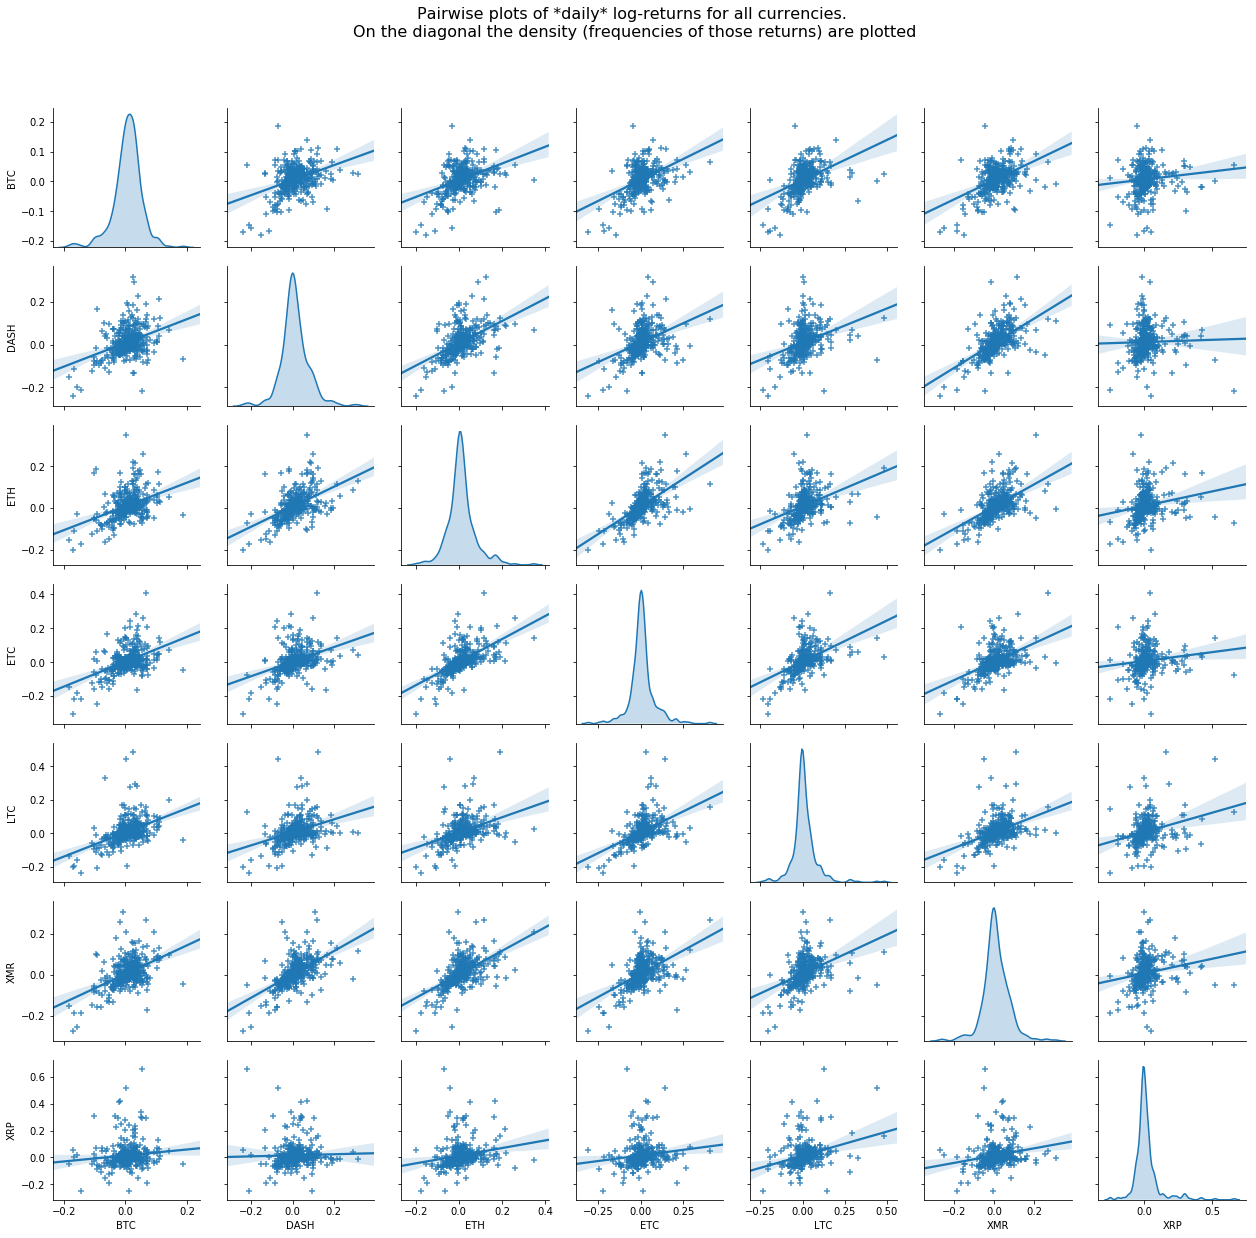

In [494]:
ax = sns.pairplot(daily_lr, kind='reg', diag_kind='kde', markers="+",
                  diag_kws={'shade': True})
plt.subplots_adjust(top=0.9)
_ = ax.fig.suptitle('Pairwise plots of *daily* log-returns for all currencies. '
                    '\nOn the diagonal the density (frequencies of those returns) are plotted',
                    fontsize=16)

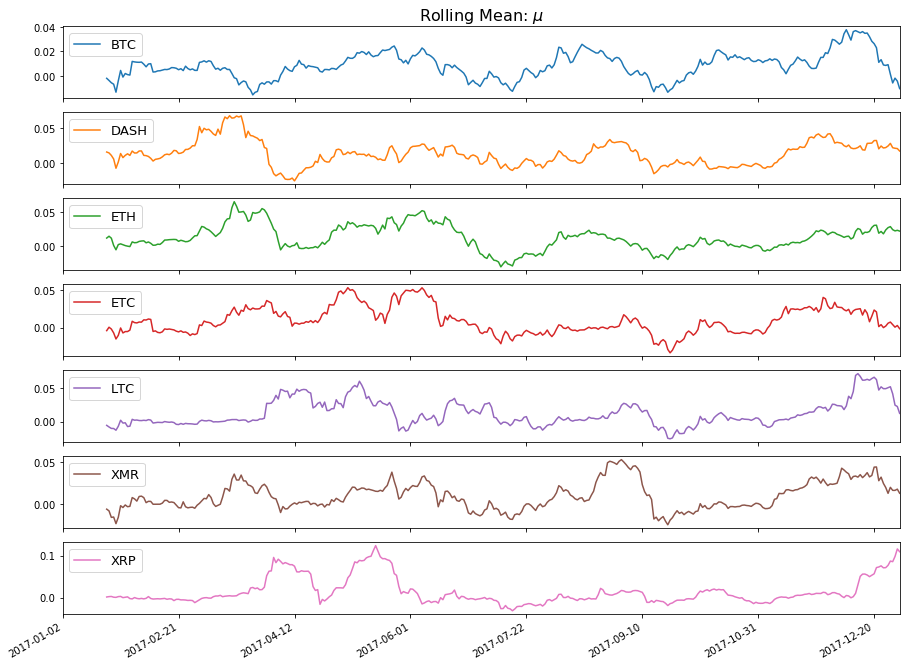

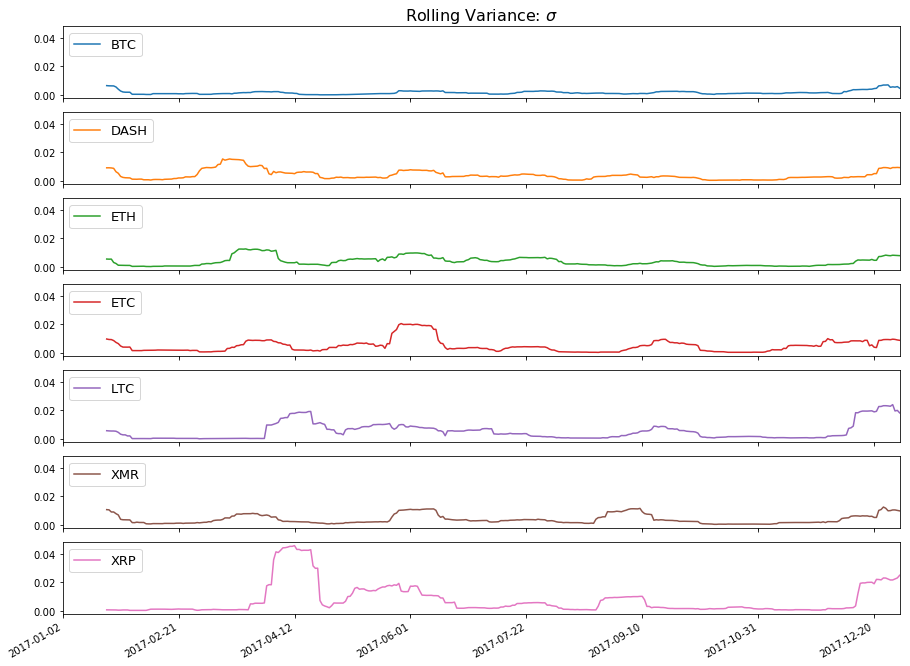

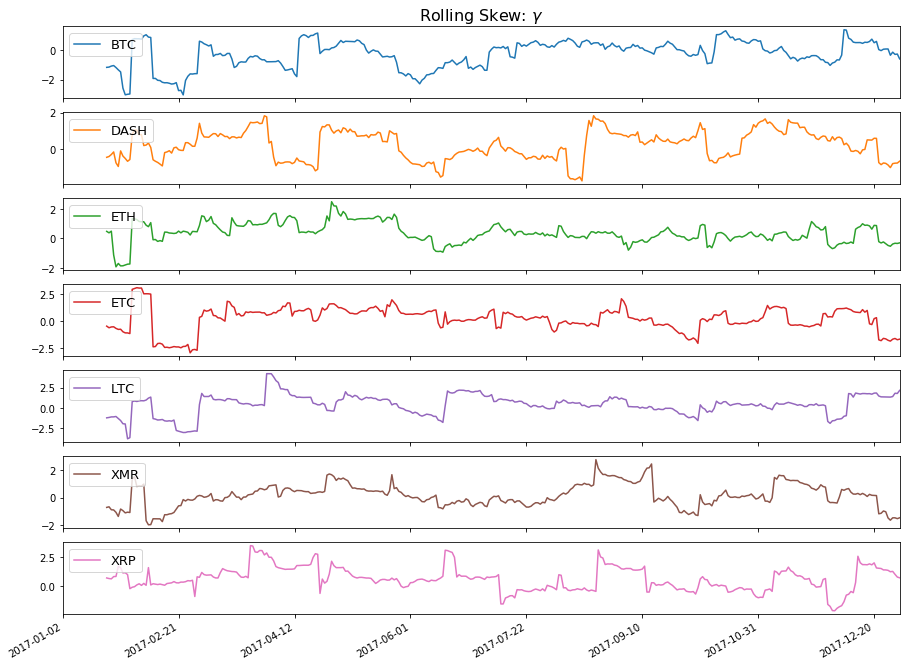

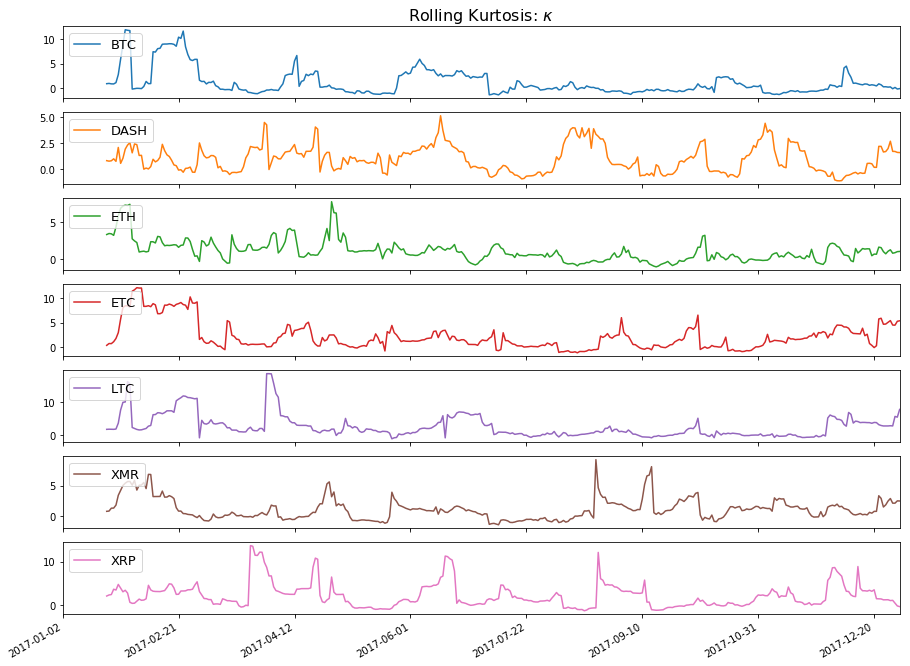

In [492]:
# display rolling moments for a 20 day rolling window
mean, var, skew, kurt = rolling_moments(daily_lr, frame_size=20, fig_size=(15, 12), legend_loc='upper left')